In [1]:
import os
import copy
import time 
import torch
import random
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import datasets, transforms, models



In [2]:
input_size = 224
batch_size = 50
data_dir = "./kaggle_dog_vs_cat/data/"
model_file = "./kaggle_dog_vs_cat/model/model.pth"
dataset_testdir = "./kaggle_dog_vs_cat/data/test/"

In [3]:
train_transforms = transforms.Compose([
                                        transforms.RandomResizedCrop(input_size),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                      ])

test_transforms = transforms.Compose([
                                       transforms.Resize(input_size),
                                       transforms.CenterCrop(input_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
                                      ])

train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform = train_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir, "val"), transform = test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, shuffle = True, num_workers=4)

In [4]:
#- dataloader本质是一个可迭代对象，使用iter()访问，不能使用next()访问；

#- 使用iter(dataloader)返回的是一个迭代器，然后可以使用next访问；
# data_iter = iter(trainloader)
# images, labels= next(data_iter)
# print(images.shape)
# print(labels.shape)

In [5]:
# x = 17
# imshow(images[x])
# print(labels[x])

In [6]:
# unloader = transforms.ToPILImage()#Convert a tensor or an ndarray to PIL Image. 图像库PIL(Python Image Library)

# plt.ion()#不能同时展示许多图 在plt.show()之后，程序会暂停到那儿，并不会继续执行下去
# #那如何展示动态图或多个窗口呢？这就要使用plt.ion()这个函数，使matplotlib的显示模式转换为交互（interactive）模式。
# #即使在脚本中遇到plt.show()，代码还是会继续执行。

# def imshow(tensor, title=None):
#     image = tensor.cpu().clone()
#     image = image.squeeze(0)
#     image = unloader(image)
#     plt.imshow(image)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)

# plt.figure()
# imshow(images[3],title="Image")

In [7]:
#神经网络
# class Net(nn.Module):
#     def __init__(self):
#         super(Net,self).__init__()
#         self.conv1 = nn.Conv2d(3,16,3,padding=1)     #输入通道数3，输出通道数16，卷积核大小3*3，padding大小1 
#         self.conv2 = nn.Conv2d(16,16,3,padding=1)
        
#         self.fc1 = nn.Linear(50*50*16,128)
#         self.fc2 = nn.Linear(128,64)
#         self.fc3 = nn.Linear(64,2)
        
#     def forward(self,x):
#         x = self.conv1(x)        #200+1-3=198
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)   #99
        
#         x = self.conv2(x)        #99+1-3=
#         x = F.relu(x)
#         x = F.max_pool2d(x, 2)   #49      
        
#         x = x.view(x.size()[0],-1) #排成一维
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))        
#         y = self.fc3(x)
        
#         return y

num_classes = 2
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features 
model.fc = nn.Linear(num_ftrs, num_classes)

for param in model.parameters():
    param.requires_grad = False
    
for param in model.fc.parameters():
    param.requires_grad = True
# model = Net()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)



In [8]:
# train
N = 10

def train(model, dataloader, loss_fn, optimizer, epoch):
#     best_acc = 0.
#     model.load_state_dict(torch.load(model_file))
#     best_model_wts = copy.deepcopy(model.state_dict())
    running_loss = 0.
    running_corrects = 0.
    corrects =0.
    lossing = 0.
    correcting = 0.

    for idx,(inputs, labels) in enumerate(dataloader):
        output = model(inputs)
        loss = loss_fn(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = output.argmax(dim=1)        #返回张量中所有元素的最大值的索引。
        running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
        running_loss += loss.item()
        if  idx % N == 0:
            lossing = running_loss - lossing
            correcting = running_corrects - correcting
            runloss = lossing / (batch_size * N)
            acc = correcting / (batch_size * N)* 100.                
            lossing = running_loss
            correcting = running_corrects
            print("iteration: {}, Loss: {}, acc:{}".format(idx * batch_size, runloss, acc))


    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)*100.
    print("epoch:{} loss:{}, acc:{}".format(epoch, epoch_loss, epoch_acc))
#         if epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#     model.load_state_dict(best_model_wts)
#     return model        
        
         

In [9]:
#test
def test(model, dataloader, loss_fn):
#     model.load_state_dict(torch.load(model_file))    
    model.eval()


    running_loss = 0.
    running_corrects = 0.

    for inputs, labels in dataloader:
        output = model(inputs)
        loss = loss_fn(output, labels)
        running_loss += loss.item()
        preds = output.argmax(dim=1)        #返回张量中所有元素的最大值的索引。
        running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)*100.
    print("loss:{}, acc:{}".format(epoch_loss, epoch_acc))

    return epoch_loss, model

best_acc = 0.
num_epochs = 2
begin = time.perf_counter()
for epoch in range(num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    train(model, trainloader, loss_fn, optimizer,num_epochs)
    epoch_acc, model = test(model, testloader, loss_fn)    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

model.load_state_dict(best_model_wts)           
end = time.perf_counter()
print("Time:" , (end-begin)/60) 
torch.save(model.state_dict(), model_file)   

iteration: 0, Loss: 0.0031493515968322753, acc:4.3999999999999995
iteration: 500, Loss: 0.025134558439254762, acc:65.4
iteration: 1000, Loss: 0.015676562905311584, acc:86.4
iteration: 1500, Loss: 0.01238801395893097, acc:89.0
iteration: 2000, Loss: 0.010391404271125794, acc:90.60000000000001
iteration: 2500, Loss: 0.00991053193807602, acc:90.8
iteration: 3000, Loss: 0.009159294545650482, acc:91.0
iteration: 3500, Loss: 0.008146845877170563, acc:91.8
iteration: 4000, Loss: 0.008244830846786498, acc:91.4
iteration: 4500, Loss: 0.007562930345535278, acc:92.60000000000001
iteration: 5000, Loss: 0.0073532586097717284, acc:92.4
iteration: 5500, Loss: 0.006878973424434662, acc:93.0
iteration: 6000, Loss: 0.007724738657474518, acc:93.2
iteration: 6500, Loss: 0.006357791811227798, acc:95.0
iteration: 7000, Loss: 0.005990595638751984, acc:96.39999999999999
iteration: 7500, Loss: 0.00701885849237442, acc:92.0
iteration: 8000, Loss: 0.007571495205163955, acc:91.8
iteration: 8500, Loss: 0.006655335

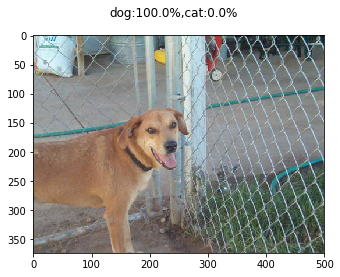

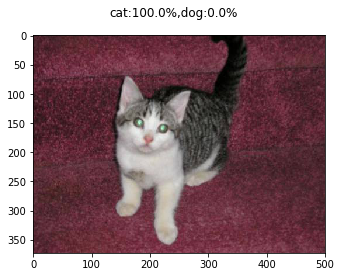

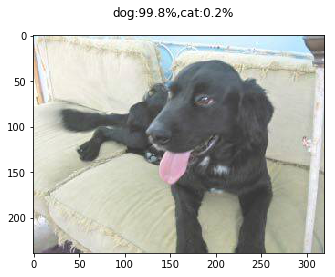

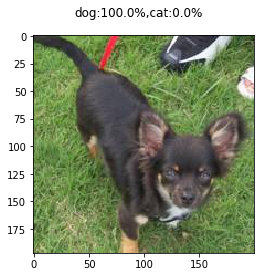

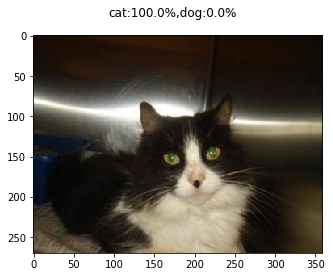

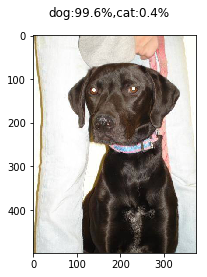

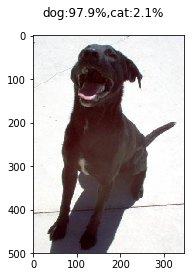

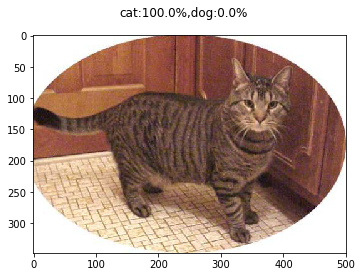

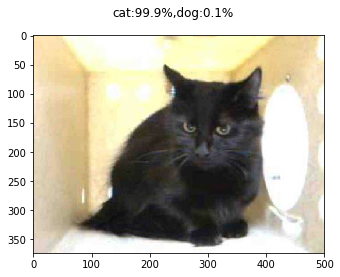

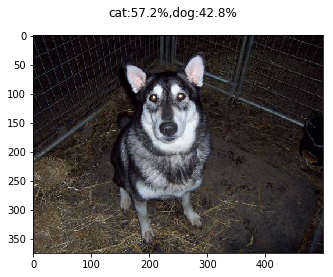

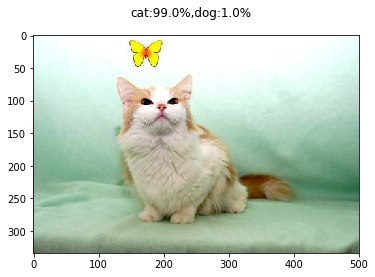

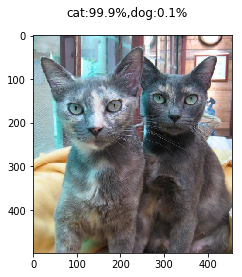

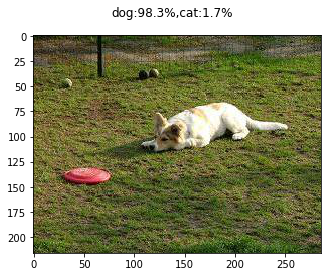

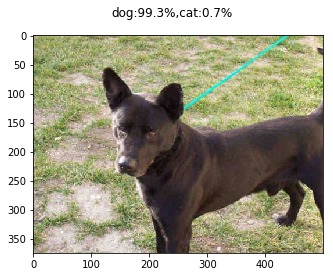

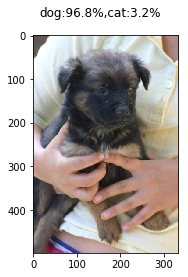

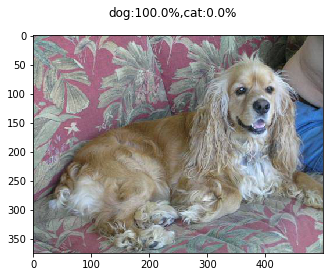

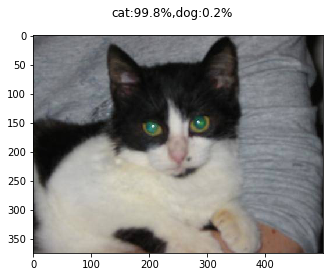

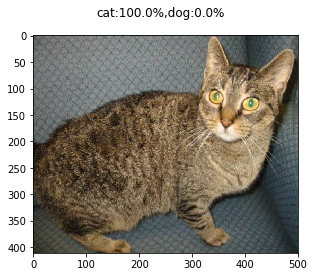

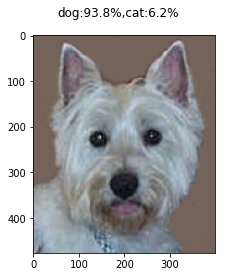

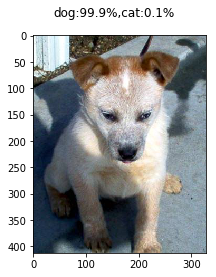

Time: 4.958832900000289


In [11]:
#测试图片的概率
M = 20

def val(model):
    model.load_state_dict(torch.load(model_file))
    model.eval()
    
    files = random.sample(os.listdir(dataset_testdir),M) #随机获取M个测试图像
    imgs = []
    imgs_data = []
    for file in files:
        img = Image.open(dataset_testdir + file)
        img_data = test_transforms(img)
        
        imgs.append(img)
        imgs_data.append(img_data)
    imgs_data = torch.stack(imgs_data)        #合成一个4维的tensor
     
    out = model(imgs_data)         #对图像进行计算
    out = F.softmax(out, dim=1)    #输出概率化
    out = out.detach().numpy()
    
    for idx in range(M):
        plt.figure()
        if out[idx, 0] > out[idx, 1]:
            plt.suptitle('cat:{:.1%},dog:{:.1%}'.format(out[idx, 0],out[idx, 1]))
        else:
            plt.suptitle('dog:{:.1%},cat:{:.1%}'.format(out[idx, 1],out[idx, 0]))
        plt.imshow(imgs[idx])
    plt.show()

begin = time.perf_counter() 
val(model)
end = time.perf_counter()
print("Time:",end-begin)     